# Recommender Network for Movies
by Alexander Köhn

![title](img/img.png)

## Information for the tester
In the following my whole Software contribution is shown via a Jupyter notebook. My Final Report is included during the Notebook at the relevant parts of my code.
The summary of the tutorials are in an extra file in my repository.

## Credits
I got information and code for this project from the Tutorial (https://keras.io/examples/structured_data/collaborative_filtering_movielens/), (https://www.tensorflow.org/recommenders/examples/basic_retrieval) and the Tensorflow API (https://www.tensorflow.org/api_docs/python/tf)

## Project Goal and underlying topic
The Project Goal is to implement a recommender system for love pairs, which want to watch a movie together during the winter holidays.
### Motivation for the underlying topic and data
The motivation is to reduce the time couples spend searching for the right movie.
Common Platforms use recommender systems with the data of the signed account. These Systems are not achieving the best results, if the account is most often used alone by one person and just used sometimes to watch movies together.
Implementing a recommender system with the input of two people, which want to watch a movie together, and an output of movies, which are good for both of them, is the Goal. This feature could be interesting for streaming platforms. If a couple has two accounts they could send invitations to each other and share their personal behavior to the others algorithm. This does not mean that the other person can see which movie the partner has watched. It only means that both underlying recommendation network know the behavior of the other.

Additionally, we want to have some more features.
1. We can decide which users interest is more important for the network. In case that someone is angry and wants to watch more like his/her interests.

## Inputs
First we need some Packages for building the network and analysing the data.

In [1]:
import pprint

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import pandas as pd
import matplotlib.pyplot as plt


In [2]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Data
We are using the Movielens 100K Dataset, which features a set with 100,000 ratings (1-5) from 943 users on 1682 movies. Tensorflow already provides a method to download the Dataset to the hard disk. After the first download the dataset from the disk will be used.

In [3]:
# Ratings data.
ratings, ratings_info = tfds.load("movielens/100k-ratings", split="train", with_info=True)
# Features of all the available movies.
movies = tfds.load("movielens/100k-movies", split="train")

As you can see, each rating consists of a movie with specific genres and a user with demographic information.

In [4]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7], dtype=int64),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


In [5]:
for x in movies.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'movie_genres': array([4], dtype=int64),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


## Analaysis of the data
We can gain a better intuition for the dataset if we gather information about statistical information of the dataset.


In [6]:
df = tfds.as_dataframe(ratings.take(100000), ratings_info)
print(ratings_info.features)

FeaturesDict({
    'bucketized_user_age': float32,
    'movie_genres': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=21)),
    'movie_id': string,
    'movie_title': string,
    'raw_user_age': float32,
    'timestamp': int64,
    'user_gender': bool,
    'user_id': string,
    'user_occupation_label': ClassLabel(shape=(), dtype=int64, num_classes=22),
    'user_occupation_text': string,
    'user_rating': float32,
    'user_zip_code': string,
})


In [7]:
df.head(10)

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'
5,18.0,"[7, 16]",b'325',b'Crash (1996)',19.0,876346551,False,b'601',1,b'artist',4.0,b'99687'
6,18.0,"[2, 3, 4, 12]",b'95',b'Aladdin (1992)',19.0,882064434,True,b'710',17,b'student',3.0,b'92020'
7,25.0,"[0, 5, 14]",b'92',b'True Romance (1993)',34.0,875135363,True,b'833',21,b'writer',2.0,b'90019'
8,25.0,[4],b'425',b'Bob Roberts (1992)',27.0,880844102,True,b'916',18,b'engineer',5.0,b'N2L5N'
9,25.0,"[0, 1, 15, 18]",b'271',b'Starship Troopers (1997)',32.0,884801053,True,b'940',2,b'administrator',2.0,b'02215'


### Average age of users

We can get some statistical information out of the dataset.

Average age by all people:
32.96985
Average age of each gender:


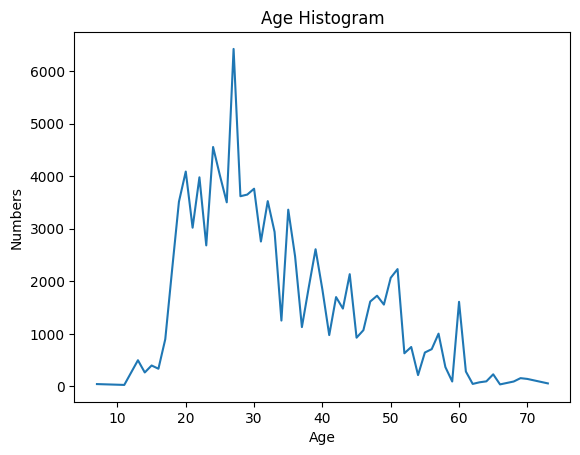

In [8]:
print("Average age by all people:")
print(df['raw_user_age'].mean())
print("Average age of each gender:")
df[['raw_user_age', 'user_gender']].groupby('user_gender').mean()
age_hist = df['raw_user_age'].value_counts().sort_index()
plt.plot(age_hist)
plt.title("Age Histogram")
plt.ylabel("Numbers")
plt.xlabel("Age")
plt.show()

As you can see in the plot the age of the users is mostly between 20 and 40.

## Prepocessing of the data
To simplify our model we will only use the user_id, movie_title and the user_rating from the Dataset.

In [9]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_zip_code": x["user_zip_code"]
})
movies = movies.map(lambda x: x["movie_title"])

We are shuffling the data of the rating to randomize the learning and to avoid a bias in the train and test data.

In [10]:
tf.random.set_seed(37)
shuffled = ratings.shuffle(100_000, seed=37, reshuffle_each_iteration=True)

We are dividing the dataset in 80 % train data and 20% test data.

In [11]:
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Now we want to get two lists. The first list unique_movie_titles consists of all the movie titles, but every title is only saved once in the list. The second list unique_user_ids consists of all the users, in the same was as the first. We need those specific lists to set up the size of our network later.

In [12]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda y: y["user_id"])
user_zip_codes = ratings.batch(1_000_000).map(lambda y: y["user_zip_code"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_user_zip_codes = np.unique(np.concatenate(list(user_zip_codes)))

print("First 10 Movie titles: ")
print(unique_movie_titles[:10])

print("\nThe total count of users: ", len(unique_user_ids))
print("The total count of movies: ", len(unique_movie_titles))

First 10 Movie titles: 
[b"'Til There Was You (1997)" b'1-900 (1994)' b'101 Dalmatians (1996)'
 b'12 Angry Men (1957)' b'187 (1997)' b'2 Days in the Valley (1996)'
 b'20,000 Leagues Under the Sea (1954)' b'2001: A Space Odyssey (1968)'
 b'3 Ninjas: High Noon At Mega Mountain (1998)' b'39 Steps, The (1935)']

The total count of users:  943
The total count of movies:  1664


## Architecture of our model
The Goal is to give a ranking of the Dataset. We are building the Class MovielensModel from tfrs.models-Model. This class inherits a network for the user, movie and ratings.

user_embeddings and movie_embeddings are both a Sequential model, which turn their specific user_ids or movie_ids into integer in the first layer using StringLookUp and map them over en embedding layer, with the length of the user or movie list and with a specific dimension.

When we call our class with the user_id and movie_id as input. The user_embeddings and movie_embedding are calculated via the two networks. With those embeddings as inputs the ratings network processes via a dense layer structure the embeddings to a single number.

To compute the loss we are calling the model and compare the ranking with the true number threw the task model, which we inherit from tfrs.model. We measure the loss with MeanSquaredError.

The steps in the model are as follows:
1. Map user_id to a "user vector" via an embedding matrix.
2. Map movie_id to a "movie vector" via an embedding matrix.
3. Compute the ranking via Dense Layers between the user vector and movie vector, to obtain the match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs


In [13]:
class MovielensModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])


        # Compute predictions.
        self.ratings = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dense(1)
        ])

        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        user_id = features["user_id"]
        movie_title = features["movie_title"]
        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)
        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        labels = features.pop("user_rating")
        rating_predictions = self(features)
        # The task computes the loss and the metrics.
        return self.task(labels=labels, predictions=rating_predictions)

    def couple_movie_recommendation(self, user_id_1, user_id_2, user_weight_1, user_weight_2, movie_list, movie_recommendation_quantity):
        test_ratings_1 = {}
        test_ratings_2 = {}
        test_ratings_combined = {}
        for movie_title in movie_list:
            test_ratings_1[movie_title] = self({
                "user_id": user_id_1,
                "movie_title": np.array([movie_title])
            })
            test_ratings_2[movie_title] = self({
                "user_id": user_id_2,
                "movie_title": np.array([movie_title])
            })
            test_ratings_combined[movie_title] = (test_ratings_1[movie_title] * user_weight_1 + test_ratings_2[movie_title] * user_weight_2) / (user_weight_1 + user_weight_2)

        test_ratings_combined = sorted(test_ratings_combined.items(), key=lambda x: x[1], reverse=True)
        print("Recommendation for the two users: \n")
        for title, score in test_ratings_combined[:movie_recommendation_quantity]:
            print(f"{title}: {score}")


The best function of this network is surely the couple_movie_recommendation. In this method we go threw the movie list and calculate for each movie the ranking for both users. We take those rankings and calculate the average. In the calculation we weigh each ranking with an integer to specify, which interests are more important.
To show our results we print a sorted list with the highest ranked movies.

## Building our model
We are getting an instance of the MovielensModel Class and compile it with the Adagrad optimizer

In [14]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

To fit the model, we input the train and test data and the number of epochs

In [15]:
cached_train = train.shuffle(100_000).batch(4096).cache()
cached_test = test.batch(2048).cache()
history = model.fit(cached_train, epochs=10, validation_data=cached_test)

Epoch 1/10
20/20 [==============================] - 4s 106ms/step - root_mean_squared_error: 1.8445 - loss: 3.2393 - regularization_loss: 0.0000e+00 - total_loss: 3.2393 - val_root_mean_squared_error: 0.9824 - val_loss: 0.9555 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9555
Epoch 2/10
20/20 [==============================] - 0s 23ms/step - root_mean_squared_error: 0.9943 - loss: 0.9801 - regularization_loss: 0.0000e+00 - total_loss: 0.9801 - val_root_mean_squared_error: 0.9349 - val_loss: 0.8747 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8747
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - root_mean_squared_error: 0.9405 - loss: 0.8835 - regularization_loss: 0.0000e+00 - total_loss: 0.8835 - val_root_mean_squared_error: 0.9258 - val_loss: 0.8541 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8541
Epoch 4/10
20/20 [==============================] - 0s 20ms/step - root_mean_squared_error: 0.9249 - loss: 0.8551 - regularization_l

## Evaluating our model
After we fitted the model, we can see how the loss and the val_loss developed over the epochs. Another good metric is the error which we can see in the second plot.

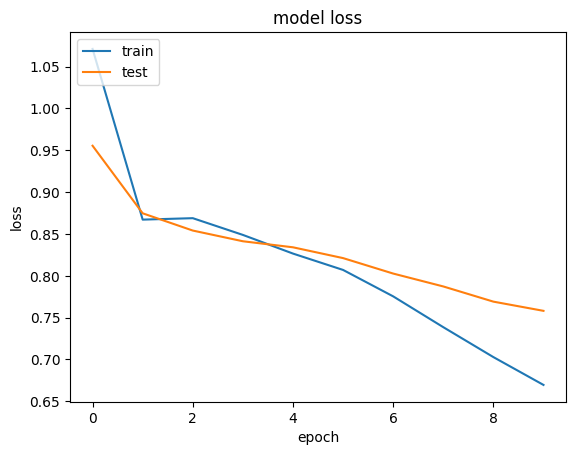

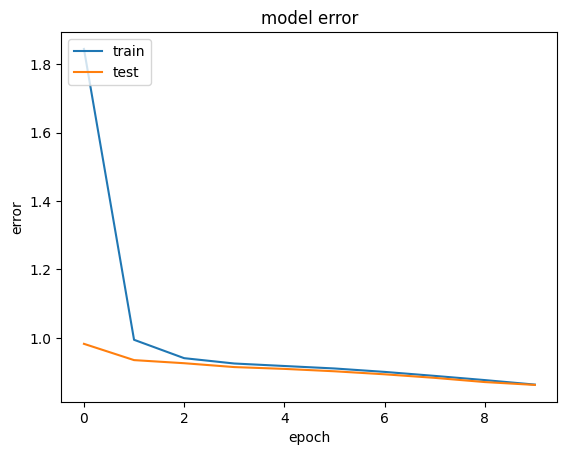

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model error")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

At the end we have an error of:

In [17]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

10/10 [==============================] - 0s 5ms/step - root_mean_squared_error: 0.8623 - loss: 0.7452 - regularization_loss: 0.0000e+00 - total_loss: 0.7452
Ranking RMSE: 0.862.


## Movie recommendation for couples
We can get a list of ranked movie, if we insert the users and their weights with a list of potential movies.

In [18]:
user_1 = np.array(["42"])
user_2 = np.array(["72"])
user_1_weight = 5
user_2_weight = 1
test_movie_titles, ind = np.unique(np.concatenate(list(movie_titles)), return_index=True)
test = test_movie_titles[np.argsort(ind)]

model.couple_movie_recommendation(user_1, user_2, user_1_weight, user_2_weight, test[:500], 30)

Recommendation for the two users: 

b'Santa with Muscles (1996)': [[5.3104076]]
b'Prefontaine (1997)': [[5.024466]]
b'Anna (1996)': [[5.005751]]
b'Slingshot, The (1993)': [[4.9342194]]
b'Great Day in Harlem, A (1994)': [[4.916161]]
b'Nico Icon (1995)': [[4.8754926]]
b'Whole Wide World, The (1996)': [[4.8129]]
b'Window to Paris (1994)': [[4.803491]]
b'Casablanca (1942)': [[4.773784]]
b'Damsel in Distress, A (1937)': [[4.7682076]]
b'Boys, Les (1997)': [[4.661148]]
b'Butcher Boy, The (1998)': [[4.6155763]]
b'Before the Rain (Pred dozhdot) (1994)': [[4.5908246]]
b'Stonewall (1995)': [[4.5753207]]
b'Flirt (1995)': [[4.5350966]]
b'World of Apu, The (Apur Sansar) (1959)': [[4.519994]]
b'High Noon (1952)': [[4.441541]]
b'Great Dictator, The (1940)': [[4.4163003]]
b"It's a Wonderful Life (1946)": [[4.41394]]
b'To Live (Huozhe) (1994)': [[4.412788]]
b'Man Who Would Be King, The (1975)': [[4.4007177]]
b'When Night Is Falling (1995)': [[4.398766]]
b'Stalker (1979)': [[4.395106]]
b'Beautiful Thing 

## Outlook
This code example is a good description of how networks can be fitted for practical situations. The concept of dividing the network into movie and user was a good idea, but right now there are less input features. This model has still a bad loss and high error rate and tends to overfit.
Next steps to proceed would be the intergration of the user and movie information into the model and after that a more specific adjusting of the parameters (even adding regularizers) to stop overfitting.